In [1]:
import torch
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11,12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v1'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_2') # cvt_nuscenes_multiclass Sparse
device = torch.device('cuda:0') # cuda:5
model_version = '0702_184708'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, _ = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='val', batch_size=4)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')
/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the fut

Dataset length: 6019


In [3]:
network.to(device)
model.to(device)
model.metrics.reset()
with_grad = True

if with_grad:
    network.train()
    # with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i != 0:
            continue
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
            elif isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    batch[k] = [i.to(device) for i in v]
            else:
                batch[k] = v
        pred = network(batch)
        loss = model.loss_func(pred,batch)
        loss[0].backward()
        vis_result = viz(batch,pred)
        break
else:
    network.eval()
    with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            if i != 1:
                continue
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            loss = model.loss_func(pred,batch)
            vis_result = viz(batch,pred)
    # if i ==5:
    
            break   
model.metrics.update(pred,batch)


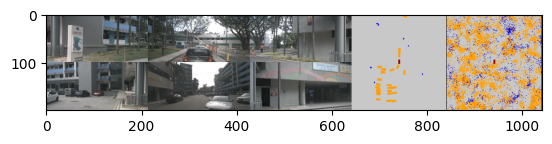

In [4]:
plt.imshow(vis_result[0])

In [5]:
for name, param in model.named_parameters():
    if param.requires_grad and param.grad is None:
        print(name)

In [6]:
# import torch
# layer = torch.nn.LayerNorm([128, 200, 200])
# print(layer.weight.shape)
# layer = torch.nn.InstanceNorm2d(128)
# print(layer.weight.shape)